In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model, radial_power_spectrum
from transform import TensorAugment, SimpleResize
from models import SimpleCNN, BigCNN

In [23]:
cdm_model='Astrid'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = random.sample(range(15000), 1000)
random.shuffle(all_indices)

val_test_transform = SimpleResize(
    size=(256, 256),
    apply_log=True  # Keep log scale
)

test_dataset = load_dataset(all_indices, transform=val_test_transform, cdm_file=cdm_file, wdm_file=wdm_file)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                         num_workers=1, pin_memory=True)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/Astrid/Maps_Mtot_Astrid_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples


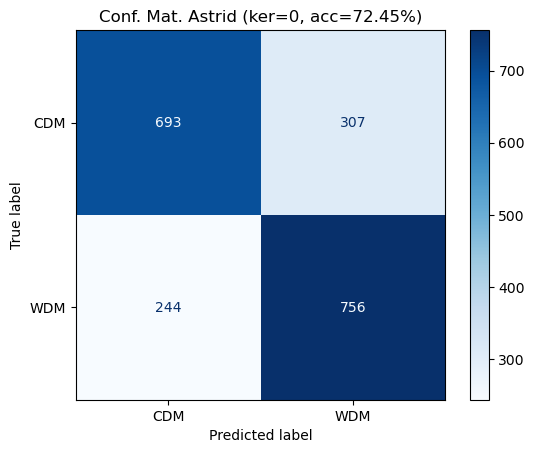

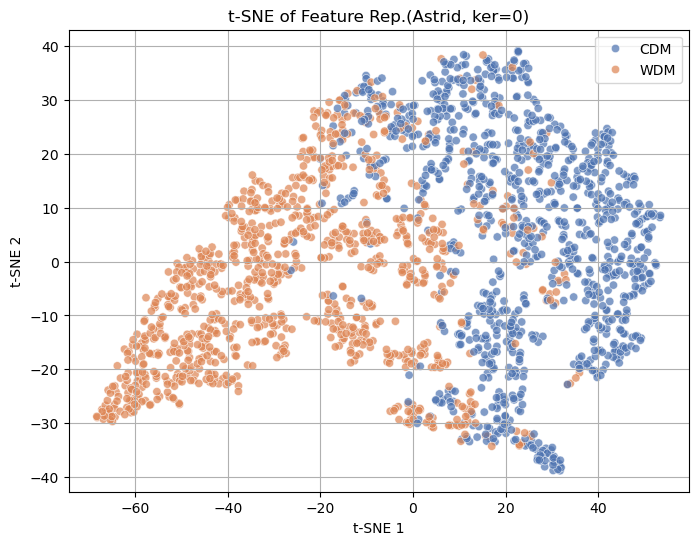

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns

# --- Set Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kern = 0

# --- Load Model ---
model = SimpleCNN().to(device)
checkpoint = torch.load(f"best_cnn_model_blur_{kern}.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


# --- Inference and Feature Extraction ---
all_preds, all_labels, features = [], [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, pks = batch
        x, y, pks = x.to(device), y.to(device), pks.to(device)

        # Pass through feature extractor
        feats = model.features(x)
        pooled_feats = model.cnn_head(feats)  # shape [B, 256]

        # Concatenate with P(k) stats
        full_input = torch.cat([pooled_feats, pks], dim=1)  # shape [B, 256 + pk_dim]

        # Classifier
        logits = model.fc(full_input).squeeze(1)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Store flattened features for t-SNE
        features.append(pooled_feats.cpu())  # or full_input.cpu() if you want both
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())


features = torch.cat(features, dim=0).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CDM", "WDM"])
disp.plot(cmap="Blues")
plt.title(f"Conf. Mat. {cdm_model} (ker={kern}, acc={acc*100:.2f}%)")
plt.savefig(f'cm_{cdm_model}_{kern}.png')
plt.show()

# --- t-SNE Plot ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
                hue=["CDM" if int(lbl)==0 else "WDM" for lbl in all_labels],
                palette="deep", alpha=0.7)
                # hue=softscores,
                # palette="viridis", alpha=0.7)
plt.title(f"t-SNE of Feature Rep.({cdm_model}, ker={kern})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.savefig(f'tSNE_{cdm_model}_{kern}.png')
plt.show()


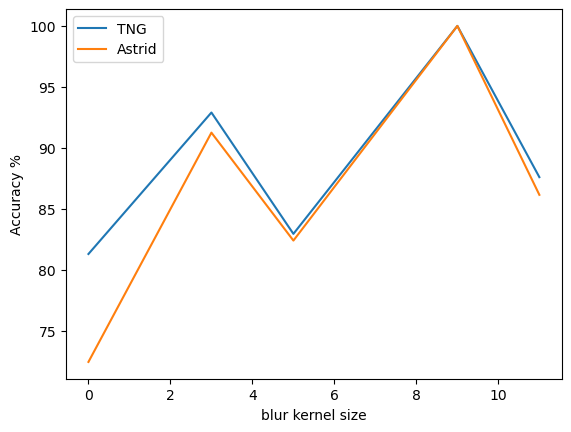

In [34]:
tng=[81.3,92.9,82.95,100,87.6]
astrid=[72.45,91.25,82.4,100,86.15]

plt.plot([0,3,5,9,11],tng,label='TNG')
plt.plot([0,3,5,9,11],astrid,label='Astrid')
plt.legend()
plt.ylabel('Accuracy %')
plt.xlabel('blur kernel size')
plt.savefig('acc.png')
plt.show()